<img src="assets/logo.png" width="800">

# Labor 02: Többváltozós lineáris regresszió

A gyakorlat során a L01-es laboron bevezetett egyváltozós modellónket fogjuk bővíteni több változós esetre.

### Ingatlanárak:

Ebben a feladatban ingatlanárak becslésére fogunk többváltozós lineáris regressziót implementálni.

Tegyük fel, hogy egy lakást szeretnénk eladni, ám ehhez szeretnénk tudni a lakás valós értékét, hogy ne veszítsünk az eladáskor. Egy lehetséges módja ennek, hogy adatot gyűjtve, majd az adatok alapján modellt készítve, becsüljük meg a lakás ingatlanpiaci árát. Adataink az ingatlan területe ($m^2$) és a szobák száma (db), illetve az értékesítéskor meghatározott ár ($) lesz.

### 1: Importjáljuk be a számunkra fontos csomagokat!
Szükségünk lesz:
- NumPy -ra a tömbkezeléshez
- MatPlotLib pyplot csomagjára a megjelenítéshez
- Pandas -ra az adatbeolvasáshoz

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Töltsük be az adatainkat! Használjuk ehhez a Pandas csomagot majd alakítsuk numpy tömbbé.

In [2]:
data = pd.read_csv('Lab2data.txt',header = None).to_numpy()    # adatok beolvasása és NumPy tömbbé alakítása
X = data[:,0:2]                                                # X rendezése
m = X.shape[0]                                                 # adatok száma
Y = data[:,2].reshape(m,1)                                     # Y rendezése oszlopvektorba

print('X:',X.shape)                                            # adattömbök méretének / adatok számának kiírása
print('Y:',Y.shape)
print('Adatok száma',m)

X: (47, 2)
Y: (47, 1)
Adatok száma 47


In [3]:
print(X)

[[2104    3]
 [1600    3]
 [2400    3]
 [1416    2]
 [3000    4]
 [1985    4]
 [1534    3]
 [1427    3]
 [1380    3]
 [1494    3]
 [1940    4]
 [2000    3]
 [1890    3]
 [4478    5]
 [1268    3]
 [2300    4]
 [1320    2]
 [1236    3]
 [2609    4]
 [3031    4]
 [1767    3]
 [1888    2]
 [1604    3]
 [1962    4]
 [3890    3]
 [1100    3]
 [1458    3]
 [2526    3]
 [2200    3]
 [2637    3]
 [1839    2]
 [1000    1]
 [2040    4]
 [3137    3]
 [1811    4]
 [1437    3]
 [1239    3]
 [2132    4]
 [4215    4]
 [2162    4]
 [1664    2]
 [2238    3]
 [2567    4]
 [1200    3]
 [ 852    2]
 [1852    4]
 [1203    3]]


### 2: Normalizáljuk az értékeinket (feature scaling & mean normalization)

Az adatainkról elképzelhető, hogy más nagyságrendekben találhatóak. Esetünkben az ingatlan területe és a szobák száma között könnyen beláthatjuk, hogy legalább egy nagyságrendi különbség van. Ilyenkor érdemes az értékeinket normalizálni, hogy egy nagyságrendbe essenek és minden bemeneti változó a [-1..1] vagy [0..1] intervallumban mozogjon. Ez a művelet a konvergenciát fogja elősegíteni, mivel nem lesz dominánsan jelen lévő változó, ami elnyomhatná a többi változó hatását. <br>
Ehhez mi az alábbi összefüggést fogjuk használni (Feature scaling and Mean normalization):

$ x = \frac{x - mean(x)}{std(x)} $

, vagyis egy adott mintából kivonjuk a minták átlagát (mean normalization) és leosztjuk a minták szórásával (feature scaling).

Grafikusan elképzelve az origó körül könnyebben megtaláljuk azt az egyenest, ami a hipotézisünknek megfelelően lefedi az adatainkat. Célszerű tehát az adatainkat ebbe a régióba trasformálni.

<img src="assets/Lab02/Pics/L02_Scaling.png" width="350">

Hozzuk létre a normalizáló függvényt!

In [4]:
def featureNormalize(X):
######################################################    
    avg    = np.mean(X,axis =0)                          # átlag kiszámolása oszloponként
    sigma  = np.std(X,axis = 0, ddof = 1)                # szórás kiszámolása oszloponként (korrigált tapasztalati)
    X_norm = (X-avg)/sigma 
######################################################
    return X_norm, avg, sigma                            # képlet alapján eredmény visszaadása

print('Normalizing X vector ...')                       
X_norm,avg,sigma = featureNormalize(X)                   # Normalizálás
X_norm=np.column_stack((np.ones(m),X_norm))              # bias hozzáadása

Normalizing X vector ...


Normalizálás után a bemeneti X mátrixhoz a BIAS tagokat is hozzáfűzzük.

### 3: Gradiens módszer
Az előző gyakorlat mintájára létrehozzuk a gradiens módszert több változós formába! Adat struktúránk a következő képpen alakul.
<img src="files/Pics/L02_Matrixok.png" width="500">

Hipotézis függvényünk több változós esetre a következő képpen írható fel:

$ h_{w}(x)=w_0x_0+w_1x_1+w_2x_2+ ... +w_nx_n $ <br>

Mátrix műveletekkel pedig:

<img src="assets/Lab02/Pics/L02_XW.png" width="550">

A költség függvény képlete: <br>

$ C(W)=C(w_0,w_1,...,w_n)=\frac{1}{2m}\sum_{i=1}^{m}(h_w(x^i)-y^i)^2 $

Tipp: Programozás során érdemes kihasználni

<img src="assets/Lab02/Pics/L02_Sum.png" width="550">

A gradiens módszer általános súlyfrissítési képlete:

$ \color{red}{(j=0...n)}\hspace{7mm} w_j:=w_j-\mu\frac{1}{2m}\sum_{i=1}^{m}((h_w(x^i)-y^i)\cdot x_j^i) $

$\color{red}{A\ szimultán\ frissítésre\ figyelni\ kell!}$

In [5]:
# Költségfüggvény
def computeCostMulti(X,Y,W):
#############################################     
    C=0
    C=(1/(2*m))*((X@W-Y).T)@(X@W-Y) 
############################################# 
    return C

In [6]:
# Gradiens módszer
def gradientDescentMulti(X,Y,W,lr,epochs):              
#############################################    
    C_history = np.zeros((epochs,1))
    temp= np.zeros((np.size(W,0),1))

    for iteration in range(0,epochs):
       for i in range(0,np.size(W,0)):
           temp[i] = W[i]-(lr/(2*m))*np.sum((X@W-Y)*(X[:,i].reshape(m,1)), axis=None)
       W=temp
       C_history[iteration]=computeCostMulti(X,Y,W)
############################################# 
    return W, C_history

In [7]:
print('Running gradient descent ...')
lr = 0.015                                                  # tanulási ráta
epochs = 1200                                               # epoch szám
W=np.zeros((3,1))                                           # kezdeti súly (0;0;0)
W,C_history= gradientDescentMulti(X_norm,Y,W,lr,epochs)     # Grádiens módszer használata
print('''Weights expected from gradient descent (approx.):
 [[340372.05039403]
 [109434.51046856]
 [ -5454.97874429 ]]
''')
print('Weights computed from gradient descent:\n', W)

if int(W[0]) == 340372 and int(W[1]) == 109434 and int(W[2]) == -5454:
    print("\n A gradientDescentMulti() függvény megfelelő. Tovább mehet.")
else:
    print("\n Valami nem stimmel. Korrekció szükséges!")

Running gradient descent ...
Weights expected from gradient descent (approx.):
 [[340372.05039403]
 [109434.51046856]
 [ -5454.97874429 ]]

Weights computed from gradient descent:
 [[340372.05039403]
 [109434.51046856]
 [ -5454.97874429]]

 A gradientDescentMulti() függvény megfelelő. Tovább mehet.


Ellenőrizzük a konvergenciát egy ábra segítségével!

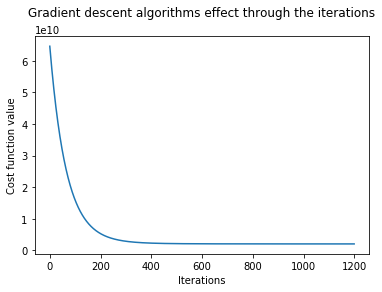

In [8]:
plt.plot(C_history)                                                                 # C_history kirajzolása
plt.title("Gradient descent algorithms effect through the iterations",pad= 20)
plt.xlabel("Iterations")
plt.ylabel("Cost function value")
plt.show()

### 4: Becslés
Becsüljük meg egy 1650 $m^2$-es, 3 szobás ingatlan árát! Figyeljünk, hogy az adatok normalizálását itt is végezzük el.

In [9]:
def predict(FEET, BED):
#############################################    
    price = (np.array([1, ((FEET-avg[0])/sigma[0]), (BED-avg[1])/sigma[1]]))@W
############################################# 
    return price

In [10]:
FEET = 1650
BED = 3
price = predict(FEET, BED)
print('''Prediction for a 1650 sq-ft / 3 bedroom house:
(predicted price should be approx. $293000) %.2f''' % price)

Prediction for a 1650 sq-ft / 3 bedroom house:
(predicted price should be approx. $293000) 293301.68


## Kicsit másként. Magasabb szintű csomagokkal

In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression

data = pd.read_csv('Lab2data.txt',header = None)                        # adatok beolvasása
X = data.iloc[:, 0:2].values.reshape(-1,2)                              # X rendezése
Y = data.iloc[:, 2].values.reshape(-1,1)                                # Y rendezése

lin_reg = LinearRegression()                                            # lineáris regressziós modell class létrehozása
lin_reg.fit(X,Y)                                                        # illesztés az X,Y alapján

pred = lin_reg.predict([[1650,3]])                                      # predikció 1650 nm és 3 szobás lakásra
print('Prediction for a 1650 sq-ft / 3 bedroom house:\n %.2f' % pred)

Prediction for a 1650 sq-ft / 3 bedroom house:
 293081.46


<div style="text-align: right">Ez a laborgyakorlat felhasznál elemeket Andrew Ng Machine Learning c. kurzusából.</div>